Nawet nie wiem jak, ale udalo mi sie to odpalic XD

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

In [2]:
es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'Hb6aErwaQCmhnl_0DbAbbA',
 'name': '250e5fef5db6',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


Udało nam się połączyć, wyprintowało to samo info jakbyśmy kliknęli w tego linka wyżej

### Stwórzmy sobie index

In [20]:
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

okej, udało nam się stworzyć index

### Replicas and Shards

In [19]:
# usuwamy poprzedni, zeby moc stworzyc nowy
es.indices.delete(index='my_index', ignore_unavailable=True)
''' es.indices.create(
    index='my_index',
    settings={
    "index": {
    "number_of_shards": 2,
    "number_of_replicas": 2
}
    },
)''' 

' es.indices.create(\n    index=\'my_index\',\n    settings={\n    "index": {\n    "number_of_shards": 2,\n    "number_of_replicas": 2\n}\n    },\n)'

### Create a document

In [21]:
document = {
    'title': 'title',
    'text': 'text',
    'created_on': '2025-02-12',
}
response = es.index(index='my_index', body=document)
response

ObjectApiResponse({'_index': 'my_index', '_id': 'XjlN-pQBLPyNZVTB9V0a', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [22]:
print(response['result'])

created


created oznacza, ze sie udalo essa

In [23]:
print(response['_shards'])

{'total': 2, 'successful': 1, 'failed': 0}


tak jak ustalilismy wczesniej, dokument zostal podzielony na 3 czesci

In [24]:
print(response['_id'])

XjlN-pQBLPyNZVTB9V0a


tutaj wiadomo, id 

In [25]:
print(response['_index'])

my_index


In [26]:
import json 
dummy_data = json.load(open("dummy_data.json"))
dummy_data

[{'title': 'Sample Title 1',
  'text': 'This is the first sample document text.',
  'created_on': '2025-02-12'},
 {'title': 'Sample Title 2',
  'text': 'Here is another example of a document.',
  'created_on': '2025-02-12'},
 {'title': 'Sample Title 3',
  'text': 'The content of the third document goes here.',
  'created_on': '2025-02-12'}]

### Insert multiple documents

In [27]:
def insert_documents(document):
    response = es.index(index='my_index', body=document)
    return response

def print_info(response):
    pprint(f"""Document ID: {response['_id']} is '{
    response['result']}' and is split into {response['_shards']['total']} shards.""")

for document in dummy_data:
    response = insert_documents(document)
    print_info(response)

"Document ID: XzlQ-pQBLPyNZVTBcl31 is 'created' and is split into 2 shards."
"Document ID: YDlQ-pQBLPyNZVTBc10Z is 'created' and is split into 2 shards."
"Document ID: YTlQ-pQBLPyNZVTBc10p is 'created' and is split into 2 shards."


### Print mapping

In [28]:
index_mapping = es.indices.get_mapping(index='my_index')
pprint(index_mapping['my_index']['mappings']['properties'])

{'created_on': {'type': 'date'},
 'text': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
          'type': 'text'},
 'title': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
           'type': 'text'}}


## Common types
### Binary

In [31]:
es.indices.delete(index='binary_index', ignore_unavailable=True)
es.indices.create(
    index='binary_index',
    mappings={
        "properties": {
            "image_data": {
                "type": "binary"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'binary_index'})

Stworzyliśmy sobie indeks na typ binarny np. na zdjecie

In [34]:
import base64

image_path = "image.png"
with open(image_path, "rb") as image_file:
    image_bytes = image_file.read()
    image_base64 = base64.b64encode(image_bytes).decode("utf-8")

image_base64[:100]

'iVBORw0KGgoAAAANSUhEUgAAAWgAAAFGCAMAAABwnfWhAAACnVBMVEXu7u4LEyoNER7+BCQEBw8HDBoIECP///8BAgYGChYNFzP+'

Stworzyliśmy teraz ?obiekt?, w sensie zapisalismy to zdjecie binarnie zakodowane i w ogole super

In [35]:
document = {
    "image_data": image_base64
}
response = es.index(index='binary_index', body=document)
response

ObjectApiResponse({'_index': 'binary_index', '_id': 'Yjlf-pQBLPyNZVTBv12Q', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

teraz stworzyliśmy dokument w którym jest ten nasz obraz zapisany

In [37]:
response['result']
# czyli jest ok

'created'

### Others

In [38]:
es.indices.delete(index='other_common_data_types_index', ignore_unavailable=True)
es.indices.create(
    index='other_common_data_types_index',
    mappings={
        "properties": {
            "book_reference": {
                "type": "keyword"
            },
            "price": {
                "type": "float"
            },
            "publish_data": {
                "type": "date"
            },
            "is_available": {
                "type": "boolean"
            },
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'other_common_data_types_index'})

stworzyliśmy index dla tych różnych fikuśnych typów danych, teraz pora na dokument

In [40]:
document = {
    "book_reference": "978-1234567",
    "price": 47.99,
    "publish_data": "2025-02-12",
    "is_available": True
}
response = es.index(index='other_common_data_types_index', body=document)
response

ObjectApiResponse({'_index': 'other_common_data_types_index', '_id': 'Yzll-pQBLPyNZVTBJl14', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

### Object

In [41]:
es.indices.delete(index='object_index', ignore_unavailable=True)
es.indices.create(
    index='object_index',
    mappings={
        "properties": {
            "author": {
                "properties": {
                    "first_name": {
                        "type": "text"
                    },
                    "last_name": {
                        "type": "text"
                    }
                }
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'object_index'})

In [43]:
document = {
    "author": {
        "first_name": "John",
        "last_name": "Doe"
    }
}
response = es.index(index="object_index", body=document)
response

ObjectApiResponse({'_index': 'object_index', '_id': 'ZDmp-pQBLPyNZVTBD12P', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

### Flattened object

In [44]:
es.indices.delete(index='flattened_object_index', ignore_unavailable=True)
es.indices.create(
    index='flattened_object_index',
    mappings={
        "properties": {
            "author": {
                "type": "flattened"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'flattened_object_index'})

In [46]:
document = {
    "author": {
        "first_name": "John",
        "last_name": "Doe"
    }
}
response = es.index(index="flattened_object_index", body=document)
response

ObjectApiResponse({'_index': 'flattened_object_index', '_id': 'ZTmr-pQBLPyNZVTBfl2j', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

### Nested object

In [47]:
es.indices.delete(index="nested_object_index", ignore_unavailable=True)
es.indices.create(
    index="nested_object_index",
    mappings={
        "properties": {
            "user": {
                "type": "nested",
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'nested_object_index'})

In [49]:
documents = [
    {
        "first": "John",
        "last": "Doe"
    },
    {
        "first": "John",
        "last": "Doe"
    }
]
response = es.index(index="nested_object_index", body={"user": documents})
response

ObjectApiResponse({'_index': 'nested_object_index', '_id': 'Zzmv-pQBLPyNZVTB-116', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 1, '_primary_term': 1})

**poczytac o tym!!!!**

## Text data types
### Text

In [53]:
es.indices.delete(index='text_index', ignore_unavailable=True)
es.indices.create(
    index='text_index', 
    mappings={
        "properties": {
            "email_body": {
                "type": "text"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'text_index'})

In [54]:
document = {
    "email_body": "Hello, this is a test email."
}
response = es.index(index="text_index", body=document)
response

ObjectApiResponse({'_index': 'text_index', '_id': 'aDkF-5QBLPyNZVTBCl2I', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

### Completion
To robi nam sugestię do wypełnienia całego dokumentu:

In [56]:
es.indices.delete(index="text_completion_index", ignore_unavailable=True)
es.indices.create(
    index="text_completion_index",
    mappings={
        "properties": {
            "suggest": {
                "type": "completion"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'text_completion_index'})

In [58]:
document_1 = {
    "suggest": {
        "input": ["Mars", "Planet"]
    }
}

document_2 = {
    "suggest": {
        "input": ["Andromeda", "Galaxy"]
    }
}
es.index(index="text_completion_index", body=document_1)
es.index(index="text_completion_index", body=document_2)

ObjectApiResponse({'_index': 'text_completion_index', '_id': 'ajkI-5QBLPyNZVTBR13B', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 1, '_primary_term': 1})

In [61]:
import os
os.getcwd()

'/home/olekh'

### Delete documents

najpierw musimy sobie dodać jakieś dokumenty do usunięcia

In [70]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [71]:
document_ids = []
dummy_data = json.load(open('dummy_data.json'))
for document in dummy_data:
    response = es.index(index='my_index', body=document)
    document_ids.append(response['_id'])

In [72]:
document_ids

['bjkj-5QBLPyNZVTBoV21', 'bzkj-5QBLPyNZVTBol1I', 'cDkj-5QBLPyNZVTBol1W']

In [73]:
response = es.delete(index='my_index', id=document_ids[0])

In [74]:
pprint(response.body)

{'_id': 'bjkj-5QBLPyNZVTBoV21',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 3,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 2,
 'result': 'deleted'}


usunęliśmy dokument po id tak jak było trzeba i przy okazji zapisaliśmy go do zmiennej, więc jak ją wywołamy to pokaże, że jest usunieta <br>


### Get document

In [76]:
response = es.get(index='my_index', id=document_ids[1])
pprint(response.body)

{'_id': 'bzkj-5QBLPyNZVTBol1I',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 1,
 '_source': {'created_on': '2025-02-12',
             'text': 'Here is another example of a document.',
             'title': 'Sample Title 2'},
 '_version': 1,
 'found': True}


In [80]:
try:
    response = es.get(index='my_index', id=document_ids[0])
    pprint(response.body)
except Exception as e:
    print(e)

NotFoundError(404, "{'_index': 'my_index', '_id': 'bjkj-5QBLPyNZVTBoV21', 'found': False}")


Teraz wywaliło **error**, bo odwołaliśmy się do id, które już wcześniej usunęliśmy

### Count documents

stworze sobie to od nowa, zeby miec przejrzystosc

In [85]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')
document_ids = []
dummy_data = json.load(open('dummy_data.json'))
for document in dummy_data:
    response = es.index(index='my_index', body=document)
    document_ids.append(response['_id'])

In [86]:
response = es.count(index='my_index')
count = response['count']
print(f'Number of documents is {count}')

Number of documents is 0


Możemy sobie wykonać takie proste zapytanie

In [92]:
query = {
    "range": {
        "created_on": {
            "gte": "2025-02-13",
            "lte": "2025-02-13",
            "format": "yyyy-MM-dd"
        }
    }
}
response = es.count(index='my_index', query=query)
count = response['count']
print(f'There is {count} document matching the query')

There is 1 document matching the query


## The exists API

czy indeks istnieje

In [94]:
response = es.indices.exists(index='my_index')
response.body

True

czy dokument istnieje

In [95]:
response = es.exists(index='my_index', id=document_ids[0])
response.body

True

### Update document

będziemy działać na tym samym pliku

Najpierw jeśli dokument już jest w indeksie

In [96]:
response = es.update(
    index='my_index',
    id=document_ids[0],
    script={
        "source": "ctx._source.title = params.title", # tego chyba sie uzywa, zeby sie dostac do dokumentu? mw
        "params": {
            "title": "New Title"
        }
    },
)
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 3,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 2,
 'result': 'updated'}


In [98]:
response = es.get(index='my_index', id=document_ids[0])
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 3,
 '_source': {'created_on': '2025-02-12',
             'text': 'This is the first sample document text.',
             'title': 'New Title'},
 '_version': 2,
 'found': True}


Teraz możemy też dodać nowe pole, które jeszcze nie istnieje w dokumencie

In [99]:
response = es.update(
    index='my_index',
    id=document_ids[0],
    script={
        "source": "ctx._source.new_field = 'dummy_value'",
    },
)
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 4,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 3,
 'result': 'updated'}


In [100]:
response = es.get(index='my_index', id=document_ids[0])
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 4,
 '_source': {'created_on': '2025-02-12',
             'new_field': 'dummy_value',
             'text': 'This is the first sample document text.',
             'title': 'New Title'},
 '_version': 3,
 'found': True}


Jest też druga metoda na to samo

In [101]:
response = es.update(
    index='my_index',
    id=document_ids[0],
    doc={
        "new_value_2": "dummy_value_2",
    },
)
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 5,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 4,
 'result': 'updated'}


In [102]:
response = es.get(index='my_index', id=document_ids[0])
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 5,
 '_source': {'created_on': '2025-02-12',
             'new_field': 'dummy_value',
             'new_value_2': 'dummy_value_2',
             'text': 'This is the first sample document text.',
             'title': 'New Title'},
 '_version': 4,
 'found': True}


teraz mozemy usunac pole

In [103]:
response = es.update(
    index='my_index',
    id=document_ids[0],
    script={
        "source": "ctx._source.remove('new_field')",
    },
)
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 6,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 5,
 'result': 'updated'}


In [104]:
response = es.get(index='my_index', id=document_ids[0])
pprint(response.body)

{'_id': 'dDkv-5QBLPyNZVTBrF0B',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 6,
 '_source': {'created_on': '2025-02-12',
             'new_value_2': 'dummy_value_2',
             'text': 'This is the first sample document text.',
             'title': 'New Title'},
 '_version': 5,
 'found': True}


Teraz dokument, który nie istnieje jeszcze w indeksie

In [105]:
response = es.update(
    index='my_index',
    id="1",
    doc={
        "book_id": 1234,
        "book_name": "A book",
    },
    doc_as_upsert=True
)
pprint(response.body)

{'_id': '1',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 7,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


In [107]:
response = es.count(index="my_index")
pprint(response['count'])

4


### Bulk API

Usuniemy index, żeby stworzyć go od nowa, już za pomoca Bulk API

In [109]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

Teraz z użyciem takiego spaghetti code, tworzymy wszystko na raz w jednym zapytaniu? API

In [111]:
response = es.bulk(
    operations=[
        # Action 1, tworzy dokument w indexie
        {
            "index": {
                "_index": "my_index",
                "_id": "1"
            }
        },
        # Source 1, dodajemy mu source z wartościami
        {
            "title": "Sample Title 1",
            "text": "This is the first sample document text.",
            "created_on": "2024-09-22"
        },
        # Action 2, tworzy drugi dokument w indexie
        {
            "index": {
                "_index": "my_index",
                "_id": "2"
            }
        },
        # Source 2, tu rownież z wartościami
        {
            "title": "Sample Title 2",
            "text": "Here is another example of a document.",
            "created_on": "2024-09-24"
        },
        # Action 3, tworzymy trzeci dokument w indexie
        {
            "index": {
                "_index": "my_index",
                "_id": "3"
            }
        },
        # Source 3, także i tutaj z domyślnymi wartościami
        {
            "title": "Sample Title 3",
            "text": "The content of the third document goes here.",
            "created_on": "2024-09-24"
        },
        # Action 4, bedziemy update'ować pierwszy dokument
        {
            "update": {
                "_id": "1",
                "_index": "my_index"
            }
        },
        # Source 4, podajemy co bedziemy modyfikowac
        {
            "doc": {
                "title": "New Title"
            }
        },
        # Action 5, modyfikujemy tez drugi dokument
        {
            "update": {
                "_id": "2",
                "_index": "my_index"
            }
        },
        # Source 5, tworząc nowe pole
        {
            "doc": {
                "new_field": "dummy_value"
            }
        },
        # Action 6, teraz usuwamy trzeci dokument bez source jak wiadomo
        {
            "delete": {
                "_index": "my_index",
                "_id": "3"
            }
        },
    ],
)

pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '1',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 6,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 3,
                      'result': 'updated',
                      'status': 200}},
           {'index': {'_id': '2',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 7,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 3,
                      'result': 'updated',
                      'status': 200}},
           {'index': {'_id': '3',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 8,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
        

## The search API

teraz też trzeba od nowa dane wrzucić do lepszej pracy

tworzymy 2 indeksy 

In [3]:
es.indices.delete(index='index_1', ignore_unavailable=True)
es.indices.create(index='index_1')

es.indices.delete(index='index_2', ignore_unavailable=True)
es.indices.create(index='index_2')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'index_2'})

In [11]:
import json

dummy_data = json.load(open('dummy_data.json'))
for document in dummy_data:
    response = es.index(index='index_1', body=document)

for document in dummy_data:
    response = es.index(index='index_2', body=document)

Teraz wyszukamy wszystkie dokumenty w jednym indeksie

In [6]:
response = es.search(
    index='index_1',
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in index_1')

Found 3 documents in index_1


In [7]:
pprint(response.body)
# jak cos to tak wyglada cale response

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': '5DLE_pQBbTrnRG9OdLcf',
                    '_index': 'index_1',
                    '_score': 1.0,
                    '_source': {'created_on': '2025-02-12',
                                'text': 'This is the first sample document '
                                        'text.',
                                'title': 'Sample Title 1'}},
                   {'_id': '5TLE_pQBbTrnRG9OdLe5',
                    '_index': 'index_1',
                    '_score': 1.0,
                    '_source': {'created_on': '2025-02-13',
                                'text': 'Here is another example of a '
                                        'document.',
                                'title': 'Sample Title 2'}},
                   {'_id': '5jLE_pQBbTrnRG9OdLfH',
                    '_index': 'index_1',
                    '_score': 1.0,
                    '_source': {'created_on': '2025-02-1

In [8]:
response['hits']
# czyli liczba dokumentów, które nasze query zwraca

{'total': {'value': 3, 'relation': 'eq'},
 'max_score': 1.0,
 'hits': [{'_index': 'index_1',
   '_id': '5DLE_pQBbTrnRG9OdLcf',
   '_score': 1.0,
   '_source': {'title': 'Sample Title 1',
    'text': 'This is the first sample document text.',
    'created_on': '2025-02-12'}},
  {'_index': 'index_1',
   '_id': '5TLE_pQBbTrnRG9OdLe5',
   '_score': 1.0,
   '_source': {'title': 'Sample Title 2',
    'text': 'Here is another example of a document.',
    'created_on': '2025-02-13'}},
  {'_index': 'index_1',
   '_id': '5jLE_pQBbTrnRG9OdLfH',
   '_score': 1.0,
   '_source': {'title': 'Sample Title 3',
    'text': 'The content of the third document goes here.',
    'created_on': '2025-02-14'}}]}

In [9]:
response['hits']['hits'][0]['_source']
# tak w bólach dostaliśmy się do pierwszego dokumentu jaki dostalismt

{'title': 'Sample Title 1',
 'text': 'This is the first sample document text.',
 'created_on': '2025-02-12'}

Teraz możemy wykonać to samo zapytanie, ale na dwóch indeksach

In [10]:
response = es.search(
    index='index_1,index_2', # moglismy tez uzyc index*, jak cos to spacji nie mozna dawac, bo ją czyta, albo _all żeby mieć wszystkie
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in both indexes')

Found 6 documents in both indexes


### The search API 2

In [12]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

dummy_data = json.load(open('dummy_data.json'))
for document in dummy_data:
    response = es.index(index='my_index', body=document)

In [12]:
pprint(response.body)

{'_id': '7DLZ_pQBbTrnRG9OuLdj',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 2,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


Najpierw wyszukamy dokument, który został utworzony danego dnia

In [14]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "term": {
                "created_on": "2025-02-12"
            }
        }
    }
)
n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in my_index')

Found 1 documents in my_index


In [16]:
response['hits']['hits'] 
# to jest tresc tego dokumentu

[{'_index': 'my_index',
  '_id': '6jLZ_pQBbTrnRG9Ot7ex',
  '_score': 1.0,
  '_source': {'title': 'Sample Title 1',
   'text': 'This is the first sample document text.',
   'created_on': '2025-02-12'}}]

Teraz wyszukamy dokumenty, które zawierają słowo document w sobie

In [23]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match": {
                "text": "document"
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in my_index', end='\n---------------------------\n')
pprint(response['hits']['hits'])

Found 3 documents in my_index
---------------------------
[{'_id': '6jLZ_pQBbTrnRG9Ot7ex',
  '_index': 'my_index',
  '_score': 0.13606146,
  '_source': {'created_on': '2025-02-12',
              'text': 'This is the first sample document text.',
              'title': 'Sample Title 1'}},
 {'_id': '6zLZ_pQBbTrnRG9OuLdE',
  '_index': 'my_index',
  '_score': 0.13606146,
  '_source': {'created_on': '2025-02-13',
              'text': 'Here is another example of a document.',
              'title': 'Sample Title 2'}},
 {'_id': '7DLZ_pQBbTrnRG9OuLdj',
  '_index': 'my_index',
  '_score': 0.12874341,
  '_source': {'created_on': '2025-02-14',
              'text': 'The content of the third document goes here.',
              'title': 'Sample Title 3'}}]


Teraz chcemy dostać dokumenty utworzone przed 14-02-25

In [26]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "range": {
                "created_on": {
                    "lte": "2025-02-13"
            }
        }
    }
    }
)

n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in my_index', end='\n---------------------------\n')
pprint(response['hits']['hits'])

Found 2 documents in my_index
---------------------------
[{'_id': '6jLZ_pQBbTrnRG9Ot7ex',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'created_on': '2025-02-12',
              'text': 'This is the first sample document text.',
              'title': 'Sample Title 1'}},
 {'_id': '6zLZ_pQBbTrnRG9OuLdE',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'created_on': '2025-02-13',
              'text': 'Here is another example of a document.',
              'title': 'Sample Title 2'}}]


### Compounds clauses

Teraz wyszukamy dokumenty po dwóch kryteriach:
- created on 2025-02-13
- zawierajace slowo another

In [27]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "bool": {
                "must": [
                    {
                        "match": {
                            "text": "another"
                        }
                    },
                    {
                        "range": {
                            "created_on": {
                                "lte": "2025-02-13",
                                "gte": "2025-02-13"
                            }
                        }
                    }
                ]
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f'Found {n_hits} documents in my_index', end='\n---------------------------\n')
pprint(response['hits']['hits'])

Found 1 documents in my_index
---------------------------
[{'_id': '6zLZ_pQBbTrnRG9OuLdE',
  '_index': 'my_index',
  '_score': 1.9994134,
  '_source': {'created_on': '2025-02-13',
              'text': 'Here is another example of a document.',
              'title': 'Sample Title 2'}}]


In [13]:
dummy_data = json.load(open('dummy_data2.json'))
for _ in range(10):
    dummy_data += dummy_data
len(dummy_data)

5120

nw po co ale chyba zduplikowalismy sb dane mocno

In [17]:
operations = []
for document in dummy_data:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)
es.bulk(operations=operations)
2+2 # dalem to zeby ukryc tamten output
# teraz chyba dodalismy dokumenty wszystkie na raz do indeksu

4

### Size + from

In [18]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match_all" : {}
        },
        "size": 10, # zwroci max 10 dokumentow
        "from": 10 # zacznie szukanie od dziesiatego
    },
)

for hit in response['hits']['hits']:
    print(hit['_source'])

{'message': 'Keyword match in this result as well.', 'age': 40, 'price': 200.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'This is an important keyword search result.', 'age': 25, 'price': 100.0}
{'message': 'Another search result with an important keyword.', 'age': 30, 'price': 150.0}
{'message': 'Keyword match in this result as well.', 'age': 40, 'price': 200.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'This is an important keyword search result.', 'age': 25, 'price': 100.0}
{'message': 'Another search result with an important keyword.', 'age': 30, 'price': 150.0}


### Timeout

In [19]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match" : {
                "message" : "search keyword"
            }
        },
        "timeout" : "10s"
    },
)

response.body

{'took': 126,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 0.8941344,
  'hits': [{'_index': 'my_index',
    '_id': 'OJn4_pQBZ5uxMwOLJ735',
    '_score': 0.8941344,
    '_source': {'message': 'This is an important keyword search result.',
     'age': 25,
     'price': 100.0}},
   {'_index': 'my_index',
    '_id': 'OZn4_pQBZ5uxMwOLJ735',
    '_score': 0.8941344,
    '_source': {'message': 'Another search result with an important keyword.',
     'age': 30,
     'price': 150.0}},
   {'_index': 'my_index',
    '_id': 'PZn4_pQBZ5uxMwOLJ736',
    '_score': 0.8941344,
    '_source': {'message': 'This is an important keyword search result.',
     'age': 25,
     'price': 100.0}},
   {'_index': 'my_index',
    '_id': 'Ppn4_pQBZ5uxMwOLJ736',
    '_score': 0.8941344,
    '_source': {'message': 'Another search result with an important keyword.',
     'age': 30,
     'price': 150.0}},

### Aggregations

In [24]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match_all" : {}
        },
        "aggs" : {
            "avg_age": {
                "avg" : {
                    "field": "age"
                }
            },
            "max_age": {
                "max": {
                    "field": "age"
                }
            }
        }
    }
)

average_age = response['aggregations']['avg_age']['value']
max_age = response['aggregations']['max_age']['value']
print(f'Average age = {average_age}, \nMax age = {max_age}')

Average age = 31.6, 
Max age = 40.0


In [25]:
response['aggregations']

{'avg_age': {'value': 31.6}, 'max_age': {'value': 40.0}}

Teraz **kompilacja**, wybierzemy pasujące do tekstu important keyword, policzymy max cene i dodamy pare parametrow

In [32]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match": {
                "message": "important keyword"
            }
        },
        "aggs": {
            "max_price": {
                "max": {
                "field": "price"
                }
            },
            "doc_count": {
                "value_count": {
                    "field": "price"
                }
            }
        },
        #"size": 5,
        #"from": 20,
        "timeout" : "5s"
    },
)

for hit in response['hits']['hits']:
    print(hit['_source'])

max_price = response['aggregations']['max_price']['value']
print(f'Max price = {max_price}')
print(response['aggregations']['doc_count'])
len(dummy_data)

{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
Max price = 200.0
{'value': 20480}


5120

**max price szuka tylko w dokumentach pasujących do wzorca podanym w query**

W sumie to chuj wie jednak xd

### Dense vectors

Stwórzmy sobie indeks, który bedzie przechowywał wektor

In [34]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index='my_index',
    mappings={
        "properties": {
            "sides_length": {
                "type": "dense_vector",
                "dims": 4
            },
            "shape": {
                "type": "keyword"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

Tworzymy dokument z jakimś wektorem

In [35]:
response = es.index(
    index='my_index',
    id=1,
    document={
        "shape": "square",
        "sides_length": [5, 5, 5, 5],
    }
)

pprint(response.body)

{'_id': '1',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 0,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


### Embedding documents

In [38]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index='my_index',
    mappings={
        "properties": {
            "embedding": {
                "type": "dense_vector",
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

**tworzymy sobie model**

In [44]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [45]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
model = model.to(device)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [48]:
documents = json.load(open('dummy_data.json'))
documents

[{'title': 'Sample Title 1',
  'text': 'This is the first sample document text.',
  'created_on': '2025-02-12'},
 {'title': 'Sample Title 2',
  'text': 'Here is another example of a document.',
  'created_on': '2025-02-13'},
 {'title': 'Sample Title 3',
  'text': 'The content of the third document goes here.',
  'created_on': '2025-02-14'}]

teraz bedziemy embeddować te dokumenty

In [50]:
def get_embedding(text):
    return model.encode(text) # zwroci nam dense wektor

operations = []
for document in documents:
    operations.append({'index': {'_index': 'my_index'}}) # indeksujemy dokumenty w indeksie o nazwie my_index XDD
    operations.append({
        **document,
        'embedding': get_embedding(document['text']),
    })

response = es.bulk(operations=operations) # teraz uzywajac bulk api, zrobimy wszystko na raz wiadomo co jest 5
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': 'O5pR_5QBZ5uxMwOLqw0V',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 3,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'PJpR_5QBZ5uxMwOLqw0V',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 4,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'PZpR_5QBZ5uxMwOLqw0V',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 5,
                      '_shards': {'failed': 0, 'successful': 1, '

teraz mozemy sprawdzic czy sie dodalo to embedding

In [56]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "match_all": {}}
        }
)
# pprint(response.body) jak co to jest ok, ale jest zjaebiscie duzo tekstu

Teraz możemy sprawdzić mapping, aby zobaczyć czy serio ma tyle wymiarów ile powinno

In [58]:
response = es.indices.get_mapping(index='my_index')
pprint(response.body)

{'my_index': {'mappings': {'properties': {'created_on': {'type': 'date'},
                                          'embedding': {'dims': 384,
                                                        'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'},
                                          'text': {'fields': {'keyword': {'ignore_above': 256,
                                                                          'type': 'keyword'}},
                                                   'type': 'text'},
                                          'title': {'fields': {'keyword': {'ignore_above':

### KNN

In [59]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index='my_index',
    mappings={
        "properties": {
            "embedding": {
                "type": "dense_vector",
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [60]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [61]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [62]:
model = model.to(device)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [63]:
documents = json.load(open('knn_search.json'))
documents

[{'id': 1,
  'title': 'The Solar System',
  'content': 'The Solar System consists of the Sun and the objects that orbit it, including eight planets, their moons, dwarf planets, and countless small bodies like asteroids and comets.'},
 {'id': 2,
  'title': 'Black Holes',
  'content': 'A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. They are formed when massive stars collapse under their own gravity.'},
 {'id': 3,
  'title': 'Galaxies',
  'content': 'Galaxies are vast systems that consist of stars, stellar remnants, interstellar gas, dust, and dark matter. The Milky Way is the galaxy that contains our Solar System.'},
 {'id': 4,
  'title': 'The Big Bang Theory',
  'content': 'The Big Bang Theory is the leading explanation about how the universe began. It suggests that the universe was once in an extremely hot and dense state and has been expanding ever since.'},
 {'id': 5,
  'title': 'Exoplanets',
  'content': 

Teraz znowu musimy "zembeddować" nasze dane szczególnie tekst do wektora i dodać je do indeksu

In [65]:
def get_embedding(text):
    return model.encode(text) # zwroci nam dense wektor

operations = []
for document in documents:
    operations.append({'index': {'_index': 'my_index'}}) # indeksujemy dokumenty w indeksie o nazwie my_index XDD
    operations.append({
        **document,
        'embedding': get_embedding(document['content']),
    })

response = es.bulk(operations=operations) # teraz uzywajac bulk api, zrobimy wszystko na raz wiadomo co jest 5
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': 'Ppp2_5QBZ5uxMwOLLg00',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'P5p2_5QBZ5uxMwOLLg00',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'QJp2_5QBZ5uxMwOLLg00',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

In [66]:
# tutaj sie weryfikuje czy sie powiodlo tak jak wczesniej wiadomo

**Let's go to knn**

In [68]:
query = "What is a black hole" # chcemy sie tego dowiedziec
embedded_query = get_embedding(query) # musimy skonwertować do wektora wiadomo

result = es.search(
    index='my_index',
    knn={
        "field": "embedding",
        "query_vector": embedded_query,
        "num_candidates": 5,
        "k": 3, # wybierze tylko 3 najblizsze
    }
)

n_docs = result.body['hits']['total']['value']
print(f'Found {n_docs} documents')

Found 3 documents


In [70]:
hits = result.body['hits']['hits']
for hit in hits:
    print(f'Title: {hit['_source']['title']}')
    print(f'Content: {hit['_source']['content']}')
    print(f'Score: {hit['_score']}')
    print('*'*50)

Title: Black Holes
Content: A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. They are formed when massive stars collapse under their own gravity.
Score: 0.8965888
**************************************************
Title: Dark Matter
Content: Dark matter is a type of matter that does not emit light or energy. It cannot be observed directly but is believed to make up about 27% of the universe's total mass and energy.
Score: 0.6555922
**************************************************
Title: Galaxies
Content: Galaxies are vast systems that consist of stars, stellar remnants, interstellar gas, dust, and dark matter. The Milky Way is the galaxy that contains our Solar System.
Score: 0.6281738
**************************************************


In [71]:
query = "How do we find exoplanets?" # chcemy sie tego dowiedziec
embedded_query = get_embedding(query) # musimy skonwertować do wektora wiadomo

result = es.search(
    index='my_index',
    knn={
        "field": "embedding",
        "query_vector": embedded_query,
        "num_candidates": 5,
        "k": 3, # wybierze tylko 3 najblizsze
    }
)

n_docs = result.body['hits']['total']['value']
print(f'Found {n_docs} documents')

Found 3 documents


In [72]:
hits = result.body['hits']['hits']
for hit in hits:
    print(f'Title: {hit['_source']['title']}')
    print(f'Content: {hit['_source']['content']}')
    print(f'Score: {hit['_score']}')
    print('*'*50)

Title: Exoplanets
Content: Exoplanets, or extrasolar planets, are planets that exist outside our solar system. They vary greatly in size and composition and are often found using methods like the transit method and radial velocity.
Score: 0.85656023
**************************************************
Title: The Solar System
Content: The Solar System consists of the Sun and the objects that orbit it, including eight planets, their moons, dwarf planets, and countless small bodies like asteroids and comets.
Score: 0.68916297
**************************************************
Title: Galaxies
Content: Galaxies are vast systems that consist of stars, stellar remnants, interstellar gas, dust, and dark matter. The Milky Way is the galaxy that contains our Solar System.
Score: 0.6610558
**************************************************


### Deep pagination

musimy zacząć od przygotowania danych, pamiętając że search_After wymaga id lub timestampa

In [77]:
index_name = 'my_index'
mapping = {
    "mappings": {
        "properties": {
            "timestamp": {"type": "date"},
            "value": {"type": "float"},
            "category": {"type": "keyword"},
            "description": {"type": "text"},
            "id": {"type": "keyword"},
        }
    },
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
}

es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

Musimy stworzyć jakieś dane

In [78]:
base_documents = [
    {
        "category": "A",
        "value": 100,
        "description": "First sample document"
    },
    {
        "category": "B",
        "value": 200,
        "description": "Second sample document"
    },
    {
        "category": "C",
        "value": 300,
        "description": "Third sample document"
    },
    {
        "category": "D",
        "value": 400,
        "description": "Fourth sample document"
    },
    {
        "category": "E",
        "value": 500,
        "description": "Fifth sample document"
    }
]

tutaj będziemy duplikowac dokumenty, zeby byli ich 100k, kazdemu dodamy id, timestampa i wartosc damy losową, zeby byly inne

In [80]:
import random
from datetime import datetime, timedelta

def generate_bulk_data(base_documents, target_size=100_000):
    documents = []
    base_count = len(base_documents)
    duplications_needed = target_size // base_count

    base_timestamp = datetime.now()

    for i in range(duplications_needed):
        for document in base_documents:
            new_doc = document.copy()
            new_doc['id'] = f"doc_{len(documents)}"
            new_doc['timestamp'] = (base_timestamp - timedelta(minutes=len(documents))).isoformat()
            new_doc['value'] = document['value'] + random.uniform(-10, 10)
            documents.append(new_doc)
    return documents

documents = generate_bulk_data(base_documents, target_size=100_000)
print(f"Generated {len(documents)} documents")

Generated 100000 documents


teraz musimy dodać te dokumenty to indeksu oczywiscie przy uzyciu bulk api, zeby bylo szybciutko

In [81]:
operations = []
for document in documents:
    operations.append({'index': {'_index': index_name}})
    operations.append(document)
response = es.bulk(operations=operations)
pprint(response.body['errors'])

False


In [83]:
count = es.count(index=index_name)['count']
print(f"Indexed {count} documents before refresh")
es.indices.refresh(index=index_name)
count = es.count(index=index_name)['count']
print(f"Indexed {count} documents after refresh")

Indexed 100000 documents before refresh
Indexed 100000 documents after refresh


najpierw **from/size**

używamy dwóch parametrów from = 0, startujemy od początku i size = 10, wypisujemy tylko 10

In [84]:
response = es.search(
    index=index_name,
    body={
        "from": 0,
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response['hits']['hits']
for hit in hits:
    print(f"ID: {hit['_source']['id']}")

ID: doc_0
ID: doc_1
ID: doc_2
ID: doc_3
ID: doc_4
ID: doc_5
ID: doc_6
ID: doc_7
ID: doc_8
ID: doc_9


teraz **search after**

In [86]:
response = es.search(
    index=index_name,
    body={
        "size": 10,
        "sort": [ # musimy to miec
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response['hits']['hits']
for hit in hits:
    print(f"ID: {hit['_source']['id']}")
    print(f"Sort values: {hit['sort']}") # timestamp to jest i id, bo po tym sortuje
    print()

ID: doc_0
Sort values: [1739470781885, 'doc_0']

ID: doc_1
Sort values: [1739470721885, 'doc_1']

ID: doc_2
Sort values: [1739470661885, 'doc_2']

ID: doc_3
Sort values: [1739470601885, 'doc_3']

ID: doc_4
Sort values: [1739470541885, 'doc_4']

ID: doc_5
Sort values: [1739470481885, 'doc_5']

ID: doc_6
Sort values: [1739470421885, 'doc_6']

ID: doc_7
Sort values: [1739470361885, 'doc_7']

ID: doc_8
Sort values: [1739470301885, 'doc_8']

ID: doc_9
Sort values: [1739470241885, 'doc_9']



In [88]:
last_sort_values = hits[-1]['sort']
last_sort_values

[1739470241885, 'doc_9']

Teraz, żeby mieć kolejne dokumenty to dodamy parametr search_after

In [89]:
response = es.search(
    index=index_name,
    body={
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ],
        "search_after": last_sort_values
    }
)

hits = response['hits']['hits']
for hit in hits:
    print(f"ID: {hit['_source']['id']}")
    print(f"Sort values: {hit['sort']}") # timestamp to jest i id, bo po tym sortuje
    print()

ID: doc_10
Sort values: [1739470181885, 'doc_10']

ID: doc_11
Sort values: [1739470121885, 'doc_11']

ID: doc_12
Sort values: [1739470061885, 'doc_12']

ID: doc_13
Sort values: [1739470001885, 'doc_13']

ID: doc_14
Sort values: [1739469941885, 'doc_14']

ID: doc_15
Sort values: [1739469881885, 'doc_15']

ID: doc_16
Sort values: [1739469821885, 'doc_16']

ID: doc_17
Sort values: [1739469761885, 'doc_17']

ID: doc_18
Sort values: [1739469701885, 'doc_18']

ID: doc_19
Sort values: [1739469641885, 'doc_19']



teraz możemy zrobić test, żeby sprawdzić która z metod jest lepsza/szybsza

In [90]:
import time

def test_from_size_pagination(es, index_name, page_size=100, max_pages=50):
    timings = []

    for page in range(max_pages):
        start_time = time.time()

        _ = es.search(
        index=index_name,
        body={
        "from": page*page_size,
        "size": page_size,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
        }
        )

        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page+1, final_time))
    return timings

In [91]:
from_size_timings = test_from_size_pagination(
    es=es,
    index_name=index_name,
    page_size=200,
    max_pages=50
)

In [93]:
def test_search_after_pagination(es, index_name, page_size=100, max_pages=50):
    timings = []
    search_after = None

    for page in range(max_pages):
        start_time = time.time()

        body = {
            "size": page_size,
            "sort": [
                {"timestamp": "desc"},
                {"id": "desc"}
            ]
        }

        if search_after: # po pierwszej iteracji juz szukamy po czyms
            body['search_after'] = search_after

        response = es.search(
            index=index_name,
            body=body
        )

        hits = response['hits']['hits'] # a to jest potrzebne, zeby wiedzialo po czym szukac
        if hits:
            search_after = hits[-1]['sort']

        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page+1, final_time))
    return timings

In [95]:
search_after_timings = test_search_after_pagination(
    es, index_name, page_size=200, max_pages=50)

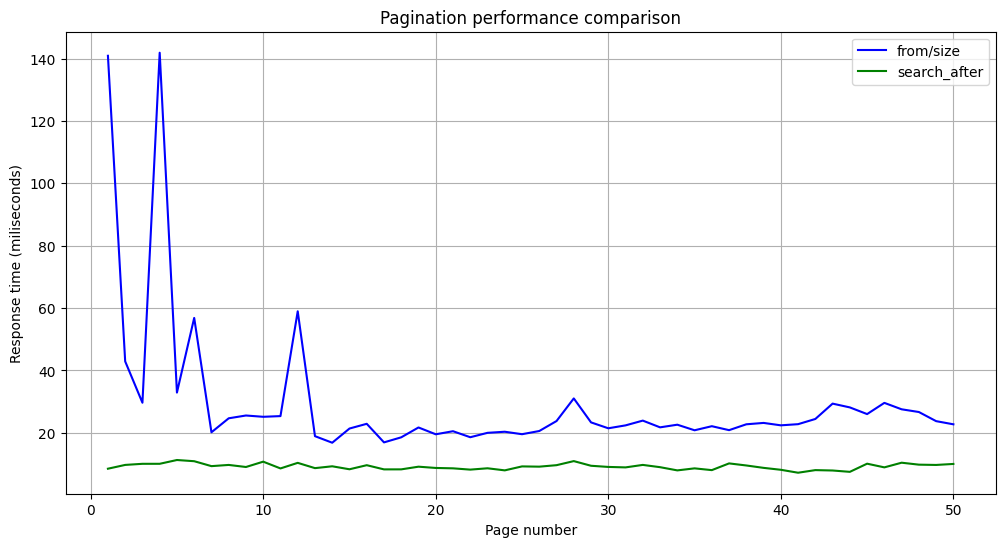

In [102]:
import matplotlib.pyplot as plt

def plot_comparison(from_size_timings, search_after_timings):
    plt.figure(figsize=(12, 6))

    pages_from_size, times_from_size = zip(*from_size_timings) # to rozpakowuje krotki zeby bylo spoko
    pages_search_after, times_search_after = zip(*search_after_timings)

    plt.plot(pages_from_size, times_from_size, 'b-', label='from/size')
    plt.plot(pages_search_after, times_search_after, 'g-', label='search_after')

    plt.xlabel('Page number')
    plt.ylabel('Response time (miliseconds)')
    plt.title('Pagination performance comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparison(from_size_timings, search_after_timings)    

Z wykresu ewidentnie wynika, że search_after jest bardziej wydajne

In [103]:
def calculate_stats(from_size_timings, search_after_timings):
    _, times_from_size = zip(*from_size_timings)
    _, times_search_after = zip(*search_after_timings)

    stats = {
        'from_size': {
            'avg_time': sum(times_from_size) / len(times_from_size),
            'max_time': max(times_from_size),
            'min_time': min(times_from_size)
        },
        'search_after': {
            'avg_time': sum(times_search_after) / len(times_search_after),
            'max_time': max(times_search_after),
            'min_time': min(times_search_after)
        }
    }
    return stats


stats = calculate_stats(from_size_timings, search_after_timings)

print("\nPerformance statistics:")
print("\n- From/Size pagination:")
print(f"Average time: {stats['from_size']['avg_time']:.3f} milliseconds")
print(f"Maximum time: {stats['from_size']['max_time']:.3f} milliseconds")
print(f"Minimum time: {stats['from_size']['min_time']:.3f} milliseconds")

print("\n- Search after pagination:")
print(f"Average time: {stats['search_after']['avg_time']:.3f} milliseconds")
print(f"Maximum time: {stats['search_after']['max_time']:.3f} milliseconds")
print(f"Minimum time: {stats['search_after']['min_time']:.3f} milliseconds")


Performance statistics:

- From/Size pagination:
Average time: 29.700 milliseconds
Maximum time: 141.897 milliseconds
Minimum time: 16.830 milliseconds

- Search after pagination:
Average time: 9.162 milliseconds
Maximum time: 11.286 milliseconds
Minimum time: 7.210 milliseconds


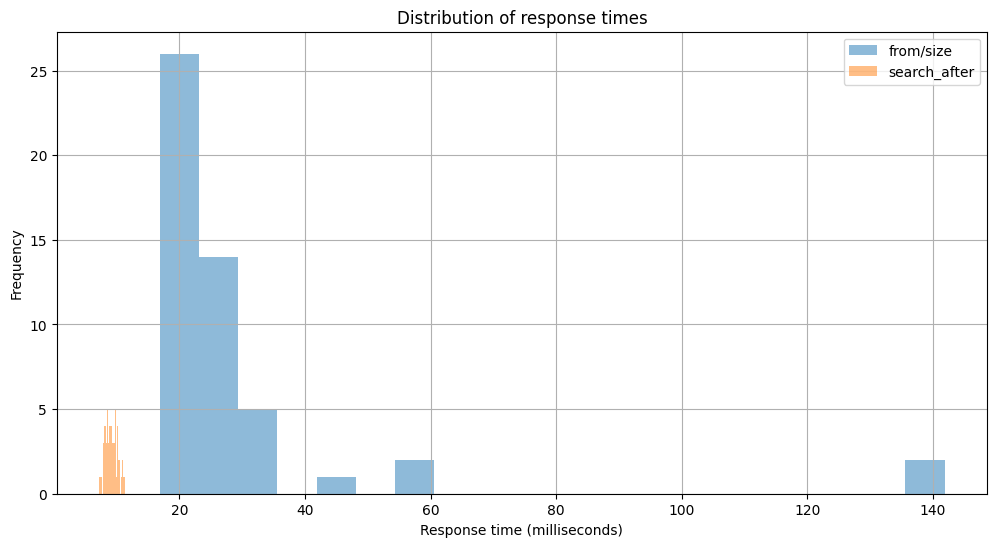

In [104]:
plt.figure(figsize=(12, 6))
_, times_from_size = zip(*from_size_timings)
_, times_search_after = zip(*search_after_timings)

plt.hist(times_from_size, alpha=0.5, label='from/size', bins=20)
plt.hist(times_search_after, alpha=0.5, label='search_after', bins=20)
plt.xlabel('Response time (milliseconds)')
plt.ylabel('Frequency')
plt.title('Distribution of response times')
plt.legend()
plt.grid(True)
plt.show()

### Ingest Pipelines

tworzymy sobie pipeline

In [4]:
response = es.ingest.put_pipeline(
    id='lowercase_pipeline',
    description='This pipeline trasnforms the text to lowercase',
    processors = [
        {
            "lowercase": {
                "field": "text"
            }
        }
    ]
)
pprint(response.body)

{'acknowledged': True}


teraz chcemy je dostac

In [5]:
response = es.ingest.get_pipeline(id='lowercase_pipeline')
pprint(response.body)

{'lowercase_pipeline': {'description': 'This pipeline trasnforms the text to '
                                       'lowercase',
                        'processors': [{'lowercase': {'field': 'text'}}]}}


Oczywiście w podobny sposób można je usunąć, ale to wiadomo 

Teraz chcemy **simulate pipeline**

In [8]:
response = es.ingest.simulate(
    id='lowercase_pipeline',
    docs=[
        {
            "_index": "my_index", # to nie ma znaczenia
            "_id": "1", # to tez, bo to tylko testy
            "_source": {
                "text": "HELLO WORLD"
            }
        }
    ]
)

pprint(response.body)

{'docs': [{'doc': {'_id': '1',
                   '_index': 'my_index',
                   '_ingest': {'timestamp': '2025-02-13T21:35:30.829397998Z'},
                   '_source': {'text': 'hello world'},
                   '_version': '-3'}}]}


widac, że działa więc spoko

teraz możemy **use the pipeline**

In [11]:
import json

dummy_data = json.load(open('dummy_data.json'))
for i, document in enumerate(dummy_data):
    uppercased_text = document['text'].upper()
    document['text'] = uppercased_text
    dummy_data[i] = document

dummy_data

[{'title': 'Sample Title 1',
  'text': 'THIS IS THE FIRST SAMPLE DOCUMENT TEXT.',
  'created_on': '2025-02-12'},
 {'title': 'Sample Title 2',
  'text': 'HERE IS ANOTHER EXAMPLE OF A DOCUMENT.',
  'created_on': '2025-02-13'},
 {'title': 'Sample Title 3',
  'text': 'THE CONTENT OF THE THIRD DOCUMENT GOES HERE.',
  'created_on': '2025-02-14'}]

In [12]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

wiadomo, dodajemy dokumenty do indeksu

In [14]:
operations = []
for document in dummy_data:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)

response = es.bulk(operations=operations, pipeline='lowercase_pipeline')
# teraz dodaliśmy nasze dane do indeksu przez pipeline przy okazji, wiec spoko
pprint(response.body)

{'errors': False,
 'ingest_took': 7,
 'items': [{'index': {'_id': '65tCAZUBZ5uxMwOLk5Pb',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 3,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '7JtCAZUBZ5uxMwOLk5Pb',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 4,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '7ZtCAZUBZ5uxMwOLk5Pb',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 5,
                      '_shards': {'failed': 0,

In [15]:
response = es.search(index='my_index')
hits = response.body['hits']['hits']

for hit in hits:
    print(hit['_source'])

{'title': 'Sample Title 1', 'created_on': '2025-02-12', 'text': 'this is the first sample document text.'}
{'title': 'Sample Title 2', 'created_on': '2025-02-13', 'text': 'here is another example of a document.'}
{'title': 'Sample Title 3', 'created_on': '2025-02-14', 'text': 'the content of the third document goes here.'}
{'title': 'Sample Title 1', 'created_on': '2025-02-12', 'text': 'this is the first sample document text.'}
{'title': 'Sample Title 2', 'created_on': '2025-02-13', 'text': 'here is another example of a document.'}
{'title': 'Sample Title 3', 'created_on': '2025-02-14', 'text': 'the content of the third document goes here.'}


**handling the failure**

In [16]:
response = es.ingest.put_pipeline(
    id='pipeline_2',
    description='Pipeline with multiple transformations, handling and ignoring failures',
    processors=[
        {
            "lowercase": {
                "field": "text",
                "on_failure": [
                    {
                        "set": {
                            "field": "text",
                            "value": "FAILED TO LOWERCASE",
                            "ignore_failure": True,
                        }
                    }
                ]
            }
        },
        {
            "set": {
                "field": "new_field",
                "value": "ADDED BY PIPELINE",
                "ignore_failure": True,
            }
        },
    ]
)
pprint(response.body)

{'acknowledged': True}


In [17]:
document = {
    'title': 'Sample Title 4',
    'created_on': '2024-09-25',
}

response = es.index(
    index='my_index',
    pipeline='pipeline_2',
    body=document
)
pprint(response.body)

{'_id': '7ptRAZUBZ5uxMwOLW5Nd',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 6,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


In [18]:
response = es.search(index='my_index')
hits = response.body['hits']['hits']
for hit in hits:
    print(hit['_source'])

{'title': 'Sample Title 1', 'created_on': '2025-02-12', 'text': 'this is the first sample document text.'}
{'title': 'Sample Title 2', 'created_on': '2025-02-13', 'text': 'here is another example of a document.'}
{'title': 'Sample Title 3', 'created_on': '2025-02-14', 'text': 'the content of the third document goes here.'}
{'title': 'Sample Title 1', 'created_on': '2025-02-12', 'text': 'this is the first sample document text.'}
{'title': 'Sample Title 2', 'created_on': '2025-02-13', 'text': 'here is another example of a document.'}
{'title': 'Sample Title 3', 'created_on': '2025-02-14', 'text': 'the content of the third document goes here.'}
{'text': 'FAILED TO LOWERCASE', 'title': 'Sample Title 4', 'created_on': '2024-09-25', 'new_field': 'ADDED BY PIPELINE'}


### Ingest processors

Stwórzmy sb jakiś dokument najpierw

In [9]:
document = {
    "price": "100.50",
    "old_name": "old_value",
    "description": "<p>This is a description with HTML.<p>",
    "username": "UserNAME",
    "category": "books",
    "title": "Example Title with Whitespace    ",
    "tags": "tag1,tag2,tag3",
    "temporary_field": "This field should be removed"
}

teraz stworzmy pipeline

In [10]:
pipeline_body = {
    "description": "Pipeline to demonstrate various ingest processors",
    "processors": [
    {
        "convert": {
            "field": "price",
            "type": "float",
            "ignore_missing": True
        }
    },
    {
        "rename": {
            "field": "old_name",
            "target_field": "new_name"
        }
    },
    {
        "set": {
            "field": "status",
            "value": "active"
        }
    },
    {
        "html_strip": {
            "field": "description"
        }
    },
    {
        "lowercase": {
            "field": "username"
        }
    },
    {
        "uppercase": {
            "field": "category"
        }
    },
    {
        "trim": {
            "field": "title"
        }
    },
    {
        "split": {
            "field": "tags",
            "separator": ","
        }
    },
    {
        "remove": {
            "field": "temporary_field"
        }
    },
    {
        "append": {
            "field": "tags",
            "value": ["new_tag"]
        }
    }
    ]
}

            
pipeline_id = "multi_steps_pipeline"
es.ingest.put_pipeline(id=pipeline_id, body=pipeline_body)
print(f'Pipeline {pipeline_id} created succesfully!')

Pipeline multi_steps_pipeline created succesfully!


In [11]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

response = es.index(index='my_index', document=document, pipeline=pipeline_id)
pprint(response.body)

{'_id': '6XkoBJUBgfO6oc4oIGLt',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 0,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


In [12]:
response = es.search(index='my_index')
hits = response.body['hits']['hits']

for hit in hits:
    pprint(hit['_source'])

{'category': 'BOOKS',
 'description': '\nThis is a description with HTML.\n',
 'new_name': 'old_value',
 'price': 100.5,
 'status': 'active',
 'tags': ['tag1', 'tag2', 'tag3', 'new_tag'],
 'title': 'Example Title with Whitespace',
 'username': 'username'}


### Filters in depth

najpierw wiadomo, trzeba dodać dane

In [13]:
import json

es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

operations = []
clothes_documents = json.load(open('clothes.json'))

for document in clothes_documents:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)

response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '6nlWBJUBgfO6oc4oBGL0',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '63lWBJUBgfO6oc4oBGL0',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '7HlWBJUBgfO6oc4oBGL0',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

Zacznijmy od simple filters

Wybierzemy tylko marki adidas i kolor zolty

In [15]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "bool": {
                "filter": [
                    {
                        "term": {
                            "brand": "adidas"
                        }
                    },
                    {
                        "term": {
                            "color": "yellow"
                        }
                    }
                ]
            }
        },
        "size": 100
    },
)

hits = response.body['hits']['hits']
print(f'Found {len(hits)} documents')

Found 6 documents


### Post filters
czyli filtry z agregacjami <br>
Najpierw wybierzemy brand gucii, potem agregacja, zeby policzyc ile jest dokumentow dla kazdego koloru <br>
Potem pozniej filtered aggregation, color_red zliczająca ile modeli w dokumentach ma kolor czerwony <br>
Na koniec post_filter po agregacjach zwraca tylko czerwone

In [18]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "bool": {
                "filter": {
                    "term": {
                        "brand": "gucci" # najpierw chcemy tylko produkty marki gucci
                    }
                }
            }
        },
        "aggs": {
            "colors": {
                "terms": {
                    "field": "color.keyword" # teraz zliczamy kolory dla gucci, musi byc keyword
                }
            },
            "color_red": {
                "filter": {
                    "term": { 
                        "color.keyword": "red" # teraz wybieramy tylko czerwone ubrania marki gucci
                    }
                },
                "aggs": {
                    "models": {
                        "terms": {
                            "field": "model.keyword" # teraz w tych czerwonych ciuchach gucci zliczamy jakie kolory tam wystepuja
                        }
                    }
                }
            }
        },
                "post_filter": {
                "term": {
                    "color": "red" # a na koniec juz wybieramy tylko czerwone gucci
                }
            }
    }
)
pprint(response.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'aggregations': {'color_red': {'doc_count': 12,
                                'models': {'buckets': [{'doc_count': 3,
                                                        'key': 'model_1'},
                                                       {'doc_count': 1,
                                                        'key': 'model_14'},
                                                       {'doc_count': 1,
                                                        'key': 'model_16'},
                                                       {'doc_count': 1,
                                                        'key': 'model_2'},
                                                       {'doc_count': 1,
                                                        'key': 'model_26'},
                                                       {'doc_count': 1,
                                                        'key': 'model_2

możemy się teraz odwoływać do pojedynczych agregacji np. kolorow

In [19]:
colors_aggregation = response.body['aggregations']['colors']['buckets']
pprint(colors_aggregation)

[{'doc_count': 12, 'key': 'red'},
 {'doc_count': 8, 'key': 'blue'},
 {'doc_count': 6, 'key': 'green'},
 {'doc_count': 4, 'key': 'yellow'}]


teraz sie odwolamy do tego ile roznych modeli jest w czerwonych gucci

In [21]:
color_red_aggregation = response.body['aggregations']['color_red']['models']['buckets']
pprint(color_red_aggregation)

[{'doc_count': 3, 'key': 'model_1'},
 {'doc_count': 1, 'key': 'model_14'},
 {'doc_count': 1, 'key': 'model_16'},
 {'doc_count': 1, 'key': 'model_2'},
 {'doc_count': 1, 'key': 'model_26'},
 {'doc_count': 1, 'key': 'model_28'},
 {'doc_count': 1, 'key': 'model_3'},
 {'doc_count': 1, 'key': 'model_4'},
 {'doc_count': 1, 'key': 'model_6'},
 {'doc_count': 1, 'key': 'model_8'}]


teraz sb wydrukujemy wszystkie czerwone gucci

In [23]:
hits = response.body['hits']['hits']
for hit in hits:
    print(f"""Shirt brand: {hit['_source']['brand']}, color: {hit['_source']['color']}, and model {hit['_source']['model']}""")

Shirt brand: gucci, color: red, and model model_1
Shirt brand: gucci, color: red, and model model_3
Shirt brand: gucci, color: red, and model model_1
Shirt brand: gucci, color: red, and model model_4
Shirt brand: gucci, color: red, and model model_1
Shirt brand: gucci, color: red, and model model_2
Shirt brand: gucci, color: red, and model model_28
Shirt brand: gucci, color: red, and model model_6
Shirt brand: gucci, color: red, and model model_14
Shirt brand: gucci, color: red, and model model_26


### SQL Search API

In [3]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')
import json
operations = []
data = json.load(open('knn_search.json'))

for document in data:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)

response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '3-EqBpUBKYTyNmUO8q_-',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '4OEqBpUBKYTyNmUO868A',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '4eEqBpUBKYTyNmUO868A',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

**Simple select query**

wybieramy tytul z pierwszych pieciu dokumentow

In [4]:
query = { "query": "SELECT title FROM my_index ORDER BY id LIMIT 5" }

response = es.sql.query(body=query)
for row in response['rows']:
    print(row)

['The Solar System']
['Black Holes']
['Galaxies']
['The Big Bang Theory']
['Exoplanets']


Teraz zmienimy sobie format na json

In [8]:
query = { "query": "SELECT * FROM my_index" }

response = es.sql.query(body=query, format='json')
pprint(response.body)

{'columns': [{'name': 'content', 'type': 'text'},
             {'name': 'id', 'type': 'long'},
             {'name': 'title', 'type': 'text'}],
 'rows': [['The Solar System consists of the Sun and the objects that orbit '
           'it, including eight planets, their moons, dwarf planets, and '
           'countless small bodies like asteroids and comets.',
           1,
           'The Solar System'],
          ['A black hole is a region of space where the gravitational pull is '
           'so strong that nothing, not even light, can escape from it. They '
           'are formed when massive stars collapse under their own gravity.',
           2,
           'Black Holes'],
          ['Galaxies are vast systems that consist of stars, stellar remnants, '
           'interstellar gas, dust, and dark matter. The Milky Way is the '
           'galaxy that contains our Solar System.',
           3,
           'Galaxies'],
          ['The Big Bang Theory is the leading explanation about ho

**Filter results**

teraz ze wszystkich dokumentow wybierzemy tylko te co maja tytul black holes

In [12]:
query = { "query": "SELECT * FROM my_index" }

response = es.sql.query(
    body=query,
    filter={
        "term": {
            "title.keyword": "Black Holes"
        }
    }
)
pprint(response)

ObjectApiResponse({'columns': [{'name': 'content', 'type': 'text'}, {'name': 'id', 'type': 'long'}, {'name': 'title', 'type': 'text'}], 'rows': [['A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. They are formed when massive stars collapse under their own gravity.', 2, 'Black Holes']]})


/tmp/ipykernel_698/1257225377.py:3: DeprecationWarning: Received 'filter' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.sql.query(


**Pagination** - tego nie bardzo rozumiem, ale obetniemy wynik do 5 dokumentow przez parametr 

In [13]:
query = { "query": "SELECT * FROM my_index ORDER BY id DESC" }

response = es.sql.query(
    body=query,
    format='json',
    fetch_size=5
)
pprint(response.body)

{'columns': [{'name': 'content', 'type': 'text'},
             {'name': 'id', 'type': 'long'},
             {'name': 'title', 'type': 'text'}],
 'cursor': 'spCTBERGTAB0T0tuwjAQnXESfpvucguklgX7IlG1VEDTVgSyyQLbiWmwURhQcotKvQnifsUBwo63GD3NjN4HI8AUGEKFf4uHMwPwEDtSiYzHW5MTUxwasVT5lhAB3czo5PKHR3SAMUuqcUajJp7dVproNJdGk9BkP60S80hRJqxtcfj9c7G1LmOluSh8LsL57j36+Vz3uk+j8aZfRpPFM/hDMVuafUhf/e6rHOcLMy8/VsHVD9r+4/fbNF2ls2AQ6skgeRmJhOsA8J4gQKfu66Cs06FLoiAbWtqUdUmUl7S3YxPgBAAA//8DAA==',
 'rows': [['Space exploration involves the use of space technology to explore '
           'outer space. It includes missions to planets, moons, and other '
           'celestial bodies, aiming to discover more about the universe.',
           10,
           'Space Exploration'],
          ['The universe has been expanding since the Big Bang. Observations '
           'of distant galaxies show that they are moving away from us, which '
           'supports the idea of an expanding universe.',
           9,
           'T

/tmp/ipykernel_698/695998784.py:3: DeprecationWarning: Received 'fetch_size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.sql.query(


widac, że dostaliśmy cursor value, teraz możemy w petli robic kolejne zapytania dopoki cursor istnieje

while 'cursor' in response.body:
    response = es.sql.query(
        format='json',
        cursor=response.body['cursor'],
    )
    pprint(response.body)
    print()
# a chuj to wie

**Translate API**

teraz dostaniemy przetlumaczone zapytanie na ten jezyk query z ES

In [17]:
trans_query = { "query": "SELECT * FROM my_index WHERE content LIKE '%universe%' ORDER BY id DESC LIMIT 20" }

translated_query = es.sql.translate(body=trans_query)
pprint(translated_query.body)

{'_source': False,
 'fields': [{'field': 'content'}, {'field': 'id'}, {'field': 'title'}],
 'query': {'wildcard': {'content.keyword': {'boost': 1.0,
                                            'wildcard': '*universe*'}}},
 'size': 20,
 'sort': [{'id': {'missing': '_first',
                  'order': 'desc',
                  'unmapped_type': 'long'}}],
 'track_total_hits': -1}


### Time series data stream

musimy najpierw ustalić policy

In [8]:
policy = {
    "phases": {
        "hot": {
            "actions": {
                "rollover": {
                    "max_age": "5m", # jesli dane beda starsze niz 5 minut, to ten index pojdzie w read-only mode i stwory sie nowy
                }
            }
        },
        "delete": {
            "min_age": "20m", # a po 20 minutach sie usunie
            "actions": {
                "delete": {}
            }
        }
    }
}

response = es.ilm.put_lifecycle(name='cpu_usage_policy_2', policy=policy)
pprint(response.body)

{'acknowledged': True}


teraz tworzymy index template

In [9]:
response = es.indices.put_index_template(
    name='cpu_example_template',
    index_patterns=[
        'cpu_example_template*' # czyli pasuje do kazdego indexu zaczynajacego sie od cpu_usage_data
    ],
    data_stream={},
    template={
        "settings": {
            "index.mode": "time_series", # stosuje time series data mode
            "index.lifecycle.name": "cpu_usage_policy_2", # stosuje policy podana wczesniej
        },
        "mappings": { # tworzymy sobie pola do indeksu
            "properties": {
                "@timestamp": {
                    "type": "date"
                },
                "cpu_usage": {
                    "type": "float",
                    "time_series_metric": "gauge" 
                },
                "cpu_name": {
                    "type": "keyword", # musimy miec min. 1 keyword field
                    "time_series_dimension": True
                }
            }
        }
    },
    priority=500, # wyzsze niz 200, zeby uniknac kolizji z wbudowanymi template
        meta={
        "description": "Template for CPU usage data",
    },
    allow_auto_create=True   
)

pprint(response.body)

{'acknowledged': True}


mozemy zaczac czytac dane z cpu i je indexowac

bedziemy uzywac psutil, zeby dostac cpu%

In [10]:
import psutil
from datetime import datetime

index_alias = 'cpu_example_template'
while True:
    document = {
        '@timestamp': datetime.utcnow(),
        'cpu_usage': psutil.cpu_percent(interval=0.1),
        'cpu_name': 'i7-13650HX'
    }
    es.index(index=index_alias, document=document, refresh=True)

/tmp/ipykernel_805/2379739130.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  '@timestamp': datetime.utcnow(),


KeyboardInterrupt: 

### Analyzers

**character filters**

zaczynamy od html strip character filter

In [12]:
response = es.indices.analyze(
    char_filter=[
        "html_strip"
    ],
    text="I&apos;m so happy</b>!</p>",
)
pprint(response.body)

{'tokens': [{'end_offset': 26,
             'position': 0,
             'start_offset': 0,
             'token': "I'm so happy!\n",
             'type': 'word'}]}


**Mapping character filter**

to jest po prostu podmiana

In [14]:
response = es.indices.analyze(
    tokenizer="keyword",
    char_filter=[
        {
            "type": "mapping",
            "mappings": [
                "olek => OLEK",
                "homa => Homa",
                "agencik => nie"
            ]
    }
    ],
    text="olek homa agencik"
)
pprint(response.body)

{'tokens': [{'end_offset': 17,
             'position': 0,
             'start_offset': 0,
             'token': 'OLEK Homa nie',
             'type': 'word'}]}


**Tokenizer**

najpierw standard

jak widać, podzielil nam tekst na tokeny, gdzie kazdy z nich ma swoj typ

In [17]:
response = es.indices.analyze(
    tokenizer="standard",
    text="The 2 QUICK Brown-Foxes jumped over the lazy dog's bone."
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}, Type: {token['type']}')

Token: The, Type: <ALPHANUM>
Token: 2, Type: <NUM>
Token: QUICK, Type: <ALPHANUM>
Token: Brown, Type: <ALPHANUM>
Token: Foxes, Type: <ALPHANUM>
Token: jumped, Type: <ALPHANUM>
Token: over, Type: <ALPHANUM>
Token: the, Type: <ALPHANUM>
Token: lazy, Type: <ALPHANUM>
Token: dog's, Type: <ALPHANUM>
Token: bone, Type: <ALPHANUM>


teraz lowercase

jak widać prawie to samo tylko mamy lowercased napis, plus usuniete sa liczby

In [19]:
response = es.indices.analyze(
    tokenizer="lowercase",
    text="The 2 QUICK Brown-Foxes jumped over the lazy dog's bone."
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}, Type: {token['type']}')

Token: the, Type: word
Token: quick, Type: word
Token: brown, Type: word
Token: foxes, Type: word
Token: jumped, Type: word
Token: over, Type: word
Token: the, Type: word
Token: lazy, Type: word
Token: dog, Type: word
Token: s, Type: word
Token: bone, Type: word


whitespace

to po prostu laczy tekst w tokeny na podstawie bialych znakow

In [21]:
response = es.indices.analyze(
    tokenizer="whitespace",
    text="The 2 QUICK Brown-Foxes jumped over the lazy dog's bone."
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}, Type: {token['type']}')

Token: The, Type: word
Token: 2, Type: word
Token: QUICK, Type: word
Token: Brown-Foxes, Type: word
Token: jumped, Type: word
Token: over, Type: word
Token: the, Type: word
Token: lazy, Type: word
Token: dog's, Type: word
Token: bone., Type: word


**token filter**

apostrophe

tutaj najpierw dzielimy text na tokeny tak jak wczesniej, a potem na nich dzialamy

In [23]:
response = es.indices.analyze(
    tokenizer="standard",
    filter=[
        "apostrophe"
    ],
    text="The 2 QUICK Brown-Foxes jumped over the lazy dog's bone."
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}, Type: {token['type']}')

Token: The, Type: <ALPHANUM>
Token: 2, Type: <NUM>
Token: QUICK, Type: <ALPHANUM>
Token: Brown, Type: <ALPHANUM>
Token: Foxes, Type: <ALPHANUM>
Token: jumped, Type: <ALPHANUM>
Token: over, Type: <ALPHANUM>
Token: the, Type: <ALPHANUM>
Token: lazy, Type: <ALPHANUM>
Token: dog, Type: <ALPHANUM>
Token: bone, Type: <ALPHANUM>


### Built-in analyzers

standardowy lowercases i splits

In [26]:
response = es.indices.analyze(
    analyzer="standard",
    text="I saw comet Tsuchinshan Atlas in 2025"
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}')

Token: i
Token: saw
Token: comet
Token: tsuchinshan
Token: atlas
Token: in
Token: 2025


STop analyzer usuwa stop words plus lowercase

In [27]:
response = es.indices.analyze(
    analyzer="stop",
    text="I saw comet Tsuchinshan Atlas in 2025"
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}')

Token: i
Token: saw
Token: comet
Token: tsuchinshan
Token: atlas


keyword

traktuje cały tekst jako jeden token

In [28]:
response = es.indices.analyze(
    analyzer="keyword",
    text="I saw comet Tsuchinshan Atlas in 2025"
)
tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}')

Token: I saw comet Tsuchinshan Atlas in 2025


wiadomo, że analyzes is done both in index time and search time, pora poznac różnice

zrobimy sobie index-time analysis, w settings dictionary mamy analysis faze, ktora pokazuje jak sb radzic z tekstem <br>
**Index time**

In [30]:
index_name = "index_time_example"
settings = {
    "settings": { # tworzymy settings dictionary
        "analysis": { # tu bedzie analysis
            "char_filter": { # robimy char_filter
                "ampersand_replacement": { # o nazwie takiej 
                    "type": "mapping", # ktora robi mapping 
                    "mappings": ["& => and"] # robiac taka zamiane
                }
            },
            "analyzer": { # pozniej kolejny analyzer
                "custom_index_analyzer": { # o takiej nazwie, nasz customowy
                    "type": "custom", # customowy typ, bo to nasz analyzer jest
                    "char_filter": ["html_strip", "ampersand_replacement"], # ktory robi te dwie rzeczy
                    "tokenizer": "standard", # standardowo tokenizujemy
                    "filter": ["lowercase"] # i robimy lowercase tez
                }
            }
        }
    },
    "mappings": { # tu po prostu robimy mapping do tworzenia indexu
        "properties": {
            "content": {
                "type": "text",
                "analyzer": "custom_index_analyzer"
            }
        }
    }
}

es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body=settings)

document = {
    "content": "Visit my website https://myuniversehub.com/ & like some images!"}
response = es.index(index=index_name, id=1, body=document)
pprint(response.body)

{'_id': '1',
 '_index': 'index_time_example',
 '_primary_term': 1,
 '_seq_no': 0,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


teraz jak wyszukamy ten nasz dokument, to okaże się że nie ma w nim żadnej zmiany. 

Ponieważ ES trzyma zmienione dokumenty w inverted index oryginalny zostawiając ten sam

In [32]:
response = es.search(index=index_name, body={"query": {"match_all": {}}})
hits = response.body['hits']['hits']

for hit in hits:
    pprint(hit['_source'])

{'content': 'Visit my website https://myuniversehub.com/ & like some images!'}


teraz możemy użyć analyzera, ktory sami wczesniej stworzylismy poprzez index_name

In [33]:
response = es.indices.analyze(
    index=index_name,
    body={
        "field": "content",
        "text": "Visit my website https://myuniversehub.com/ & like some images!"
    }
)

tokens = response.body['tokens']
for token in tokens:
    print(f'Token: {token['token']}')

Token: visit
Token: my
Token: website
Token: https
Token: myuniversehub.com
Token: and
Token: like
Token: some
Token: images


teraz jest gites

**Search time**

search-time analysis transforms text tylko gdy wykonywane jest jakieś zapytanie, a nie gdy dane są indeksowae. <br>
Tutaj zrobimy search z search-time analyzer 

In [37]:
response = es.search(index=index_name, body={
    "query": {
        "match": {
            "content": {
                "query": "myuniversehub.com",
                "analyzer": "standard"
            }
        }
    }
}
                    )

hits = response.body['hits']['hits']
for hit in hits:
    print(hit['_source'])

{'content': 'Visit my website https://myuniversehub.com/ & like some images!'}


In [35]:
response = es.search(index=index_name, body=
                     {
                         "query": {
                             "match_all" : {}}})
hits = response.body['hits']['hits']
for hit in hits:
    print(hit['_source'])

{'content': 'Visit my website https://myuniversehub.com/ & like some images!'}


### Synonyms

najpierw musimy je ustawić

In [40]:
settings = {
    "settings": {
        "analysis": {
            "filter": {
                "synonym_filter": {
                    "type": "synonym",
                    "synonyms": [
                        "car, automobile, vehicle",
                        "tv, television",
                        "smartphone, mobile, cell phone",
                        "jupyter, jupyter notebook, jupyterlab",
                        "jupiter, mars, earth, venus, mercury, saturn, uranus, neptune => planet"
                    ]
                }
            },
            "analyzer": {
                "synonym_analyzer": {
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "synonym_filter"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "description": {
                "type": "text",
                "analyzer": "synonym_analyzer"
            }
        }
    }
}

index_name = "my_synonym_index"
es.indices.delete(index=index_name, ignore_unavailable=True)
response = es.indices.create(index=index_name, body=settings)
pprint(response.body)

{'acknowledged': True, 'index': 'my_synonym_index', 'shards_acknowledged': True}


mając stworzony index musimy dodać dokumenty, oczywiscie uzywajac bulk api

In [42]:
import json

operations = []
dummy_data = json.load(open('synonyms.json'))
for document in dummy_data:
    operations.append({"index": {"_index": index_name}})
    operations.append(document)
response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '154lC5UBI2TJsjHOAbB6',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '2J4lC5UBI2TJsjHOAbB6',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '2Z4lC5UBI2TJsjHOAbB6',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed

In [43]:
print(operations)

[{'index': {'_index': 'my_synonym_index'}}, {'description': 'I love my car and television.'}, {'index': {'_index': 'my_synonym_index'}}, {'description': 'My smartphone is amazing.'}, {'index': {'_index': 'my_synonym_index'}}, {'description': 'I love working with Jupyter notebooks.'}, {'index': {'_index': 'my_synonym_index'}}, {'description': 'I want to go to Mars.'}, {'index': {'_index': 'my_synonym_index'}}, {'description': 'I want to go to Venus.'}]


**Searching with synonyms**



In [44]:
query = {
    "query": {
        "match": {
            "description": "vehicle"
        }
    }
}

response = es.search(index=index_name, body=query)
hits = response['hits']['hits']
for hit in hits:
    print(hit['_source'])


{'description': 'I love my car and television.'}


**Expanding synonyms for search time only** <br>
mozemy uzyc synonimow tylko dla wyszukiwania, zamiast indexowania <br>

tworzymy sobie indeks, ale bez synonimow, za to z dwoma analizerami <br>
jeden index_analyzer i drugi search_analyzer

In [45]:
settings = {
    "settings": {
        "analysis": {
            "filter": {
                "synonym_filter": {
                    "type": "synonym",
                    "synonyms": [
                        "car, automobile, vehicle",
                        "tv, television"
                    ]
                }
            },
            "analyzer": {
                "index_analyzer": {
                    "tokenizer": "standard",
                    "filter": ["lowercase"]
                },
                "search_analyzer": {
                    "tokenizer": "standard",
                    "filter": ["lowercase", "synonym_filter"]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "description": {
                "type": "text",
                "analyzer": "index_analyzer",
                "search_analyzer": "search_analyzer"
            }
        }
    }
}

es.indices.delete(index=index_name)
response = es.indices.create(index=index_name, body=settings)
pprint(response.body)

{'acknowledged': True, 'index': 'my_synonym_index', 'shards_acknowledged': True}


In [46]:
operations = []
dummy_data = json.load(open('synonyms.json'))
for document in dummy_data:
    operations.append({"index": {"_index": index_name}})
    operations.append(document)
response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '3J4uC5UBI2TJsjHOILD5',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '3Z4uC5UBI2TJsjHOILD5',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '3p4uC5UBI2TJsjHOILD5',
                      '_index': 'my_synonym_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed

In [47]:
query = {
    "query": {
        "match": {
            "description": "vehicle"
        }
    }
}

response = es.search(index=index_name, body=query)

print("Search results")
for hit in response['hits']['hits']:
    print(hit['_source'])

Search results
{'description': 'I love my car and television.'}


In [48]:
# tez dziala i spoko

### Common options

**human-readable output**

In [49]:
response = es.cluster.stats(human=True)
pprint(response['nodes']['jvm'])

{'max_uptime': '6.6h',
 'max_uptime_in_millis': 24081846,
 'mem': {'heap_max': '3.7gb',
         'heap_max_in_bytes': 4001366016,
         'heap_used': '584mb',
         'heap_used_in_bytes': 612370608},
 'threads': 93,
 'versions': [{'bundled_jdk': True,
               'count': 1,
               'using_bundled_jdk': True,
               'version': '22.0.1',
               'vm_name': 'OpenJDK 64-Bit Server VM',
               'vm_vendor': 'Oracle Corporation',
               'vm_version': '22.0.1+8-16'}]}


### Response filtering

Najpierw **inclusive filtering**

In [51]:
# najpierw najpierw to wszystko xd
response = es.search(
    index=index_name,
    body={
        "query": {
            "match_all": {}
        }
    }
)
pprint(response.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': '3J4uC5UBI2TJsjHOILD5',
                    '_index': 'my_synonym_index',
                    '_score': 1.0,
                    '_source': {'description': 'I love my car and '
                                               'television.'}},
                   {'_id': '3Z4uC5UBI2TJsjHOILD5',
                    '_index': 'my_synonym_index',
                    '_score': 1.0,
                    '_source': {'description': 'My smartphone is amazing.'}},
                   {'_id': '3p4uC5UBI2TJsjHOILD5',
                    '_index': 'my_synonym_index',
                    '_score': 1.0,
                    '_source': {'description': 'I love working with Jupyter '
                                               'notebooks.'}},
                   {'_id': '354uC5UBI2TJsjHOILD5',
                    '_index': 'my_synonym_index',
                    '_score': 1.0,
                    '_source': {'de

In [52]:
# teraz juz prawdziwe inclusive filtering
response = es.search(
    index=index_name,
    body={
        "query": {
            "match_all": {}
        }
    },
    filter_path="hits.hits._id,hits.hits._source"
)
pprint(response.body)

{'hits': {'hits': [{'_id': '3J4uC5UBI2TJsjHOILD5',
                    '_source': {'description': 'I love my car and '
                                               'television.'}},
                   {'_id': '3Z4uC5UBI2TJsjHOILD5',
                    '_source': {'description': 'My smartphone is amazing.'}},
                   {'_id': '3p4uC5UBI2TJsjHOILD5',
                    '_source': {'description': 'I love working with Jupyter '
                                               'notebooks.'}},
                   {'_id': '354uC5UBI2TJsjHOILD5',
                    '_source': {'description': 'I want to go to Mars.'}},
                   {'_id': '4J4uC5UBI2TJsjHOILD5',
                    '_source': {'description': 'I want to go to Venus.'}}]}}


**Exclusive filtering** to dodaje sie minus przed diltrem